<a href="https://colab.research.google.com/github/rumeysao/iris_flower_class/blob/main/DcGan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#GPU kullanmak için kimlik doğrulama işlemi
from google.colab import drive
drive.mount('/gdrive')
#%cd /gdrive

Mounted at /gdrive


In [ ]:
!ls "/gdrive/My Drive/DcGan"



ls: cannot access '/gdrive/My Drive/DcGan': No such file or directory


In [ ]:
import os
os.chdir("/gdrive/My Drive/DcGAN/")

In [ ]:
#Kullanacağınız donanım özelliklerini bu kod parçasını çalıştırarak görebilirsiniz.
import tensorflow as tf
tf.test.gpu_device_name()
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 13739153001364624794, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 14638920512
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 1666611506494126570
 physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"]

In [ ]:
%matplotlib inline
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
print('Tensorflow version:', tf.__version__)

In [ ]:
def show(images, n_cols=None):
    n_cols = n_cols or len(images)
    n_rows = (len(images) - 1) // n_cols + 1
    if images.shape[-1] == 1:
        images = np.squeeze(images, axis=-1)
    plt.figure(figsize=(n_cols, n_rows))
    for index, image in enumerate(images):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(image, cmap="binary")
        plt.axis("off")

## 2.ADIM: Verilerin yüklenmesi ve önişlemlerin gerçekleştirilmesi

Bu çalışmada [Fashion MNIST](https://www.kaggle.com/zalando-research/fashionmnist) veri kümesini kullanacağız ve bu veri kümesinde çok çeşitli ayakkabı, bot, sandalet, tişört, kaban, bandana vb. tekstil ürününden etiketli örnekler yer almaktadır.

In [ ]:
#Fashion MNIST veri kümesinin keras yoluyla indiriyoruz. 
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
x_train = x_train.astype(np.float32) / 255.0
x_test = x_test.astype(np.float32) / 255.0

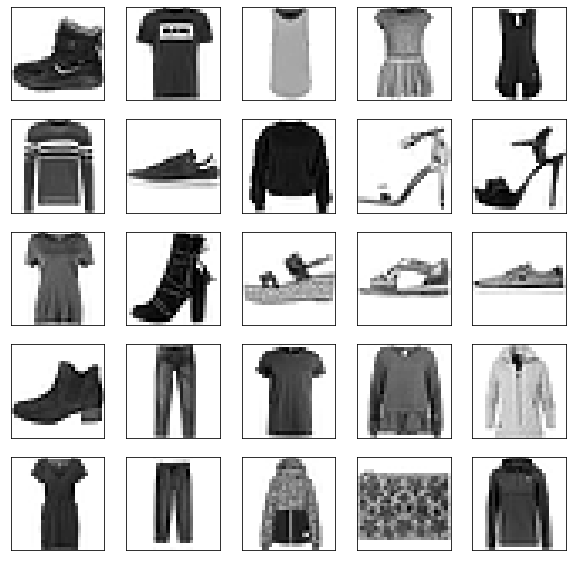

In [ ]:
# Veri kümesinden 10x10 piksel büyüklüklü 25 tane örnek ekrana yazdırıp neye benzediğine bakalım.
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train[i], cmap=plt.cm.binary)
plt.show()


## 3.ADIM: Eğtim verileri ve gruplarının oluşturulması

In [ ]:
batch_size = 32
# Bu veri kümesi, bir arabelleği buffer_size elemanları ile doldurur,
#ardından seçilen elemanları yeni elemanlarla değiştirerek rastgele örnekler.
dataset = tf.data.Dataset.from_tensor_slices(x_train).shuffle(1000)
# Bu veri kümesinin ardışık öğelerini toplu olarak birleştirir.
dataset = dataset.batch(batch_size, drop_remainder=True).prefetch(1)

## 4.ADIM: DCGAN için üretici (generator) ağının oluşturulması

Denklemde D ayırt edici (ayırıcı), G ise üretici olarak tanımlanmakta ve aralarındaki çekişme ifade ediliyor. Aslında bu temel bir *oyun teorisi* yaklaşımıdır.

Burada ters evrişim işlemi yaparak ve rastgele gürültüden başlayan bir görseller yapısı elde ediyoruz. Giderek bu üreticiyi gerçek görsellere benzer üretimler yapmasını aşağıdaki denklem yoluyla sağlıyoruz. 



In [ ]:
# ÜRETİCİ KATMANINDAKİ EVRİŞİMLİ SİNİR AĞI
num_features = 100 # öznitelik sayısı

# giriş değerini verdiğimiz features sayısına göre başlatıyoruz
# Conv2DTranpose versiyonunu kullanıyoruz. 
generator = keras.models.Sequential([
    keras.layers.Dense(7 * 7 * 128, input_shape=[num_features]),
    keras.layers.Reshape([7, 7, 128]),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2DTranspose(64, (5,5), (2,2), padding="same", activation="selu"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2DTranspose(1, (5,5), (2,2), padding="same", activation="tanh"),
])

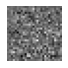

In [ ]:
noise = tf.random.normal(shape=[1, num_features])
generated_images = generator(noise, training=False)
show(generated_images, 1)

In [ ]:
discriminator = keras.models.Sequential([
    keras.layers.Conv2D(64, (5,5), (2,2), padding="same", input_shape=[28, 28, 1]),
    keras.layers.LeakyReLU(0.2),
    keras.layers.Dropout(0.3),
    keras.layers.Conv2D(128, (5,5), (2,2), padding="same"),
    keras.layers.LeakyReLU(0.2),
    keras.layers.Dropout(0.3),
    keras.layers.Flatten(),
    keras.layers.Dense(1, activation='sigmoid')
])

In [ ]:
# Üretilen görsel için ayırt edici %50nin altında bir değer üretti ilk adım için 
decision = discriminator(generated_images)
print(decision)

tf.Tensor([[0.49698335]], shape=(1, 1), dtype=float32)


## 6.ADIM: Derin Evrişimli Üretici Çekişmeli Ağınızı (DCGAN) Derlenmesi





In [ ]:
discriminator.compile(loss="binary_crossentropy", optimizer="rmsprop")
discriminator.trainable = False
gan = keras.models.Sequential([generator, discriminator])
gan.compile(loss="binary_crossentropy", optimizer="rmsprop")

## 7.ADIM: Eğitim işlemlerini görseleştirilmesi
Bu adımda progress adımlarını tanımlıyoruz. Eğitim sırasında her bir epoch da üretici modelden elde ettiğimiz sonuçları ekrana yazdıralım ve her ekrana yazdırdığımız görüntüyü kaydedelim istiyoruz. Çünkü en sonda eğitim süresince epochların sonuçlarındaki iyileşmeyi görselleştirebiliriz.



In [ ]:
from IPython import display
from tqdm import tqdm
seed = tf.random.normal(shape=[batch_size, 100])

In [ ]:
from tqdm import tqdm
def train_dcgan(gan, dataset, batch_size, num_features, epochs=5):
    generator, discriminator = gan.layers
    for epoch in tqdm(range(epochs)):
        print("Epoch {}/{}".format(epoch + 1, epochs))
        for X_batch in dataset:
            noise = tf.random.normal(shape=[batch_size, num_features])
            generated_images = generator(noise)
            X_fake_and_real = tf.concat([generated_images, X_batch], axis=0)
            y1 = tf.constant([[0.]] * batch_size + [[1.]] * batch_size)
            discriminator.trainable = True
            discriminator.train_on_batch(X_fake_and_real, y1)
            noise = tf.random.normal(shape=[batch_size, num_features])
            y2 = tf.constant([[1.]] * batch_size)
            discriminator.trainable = False
            gan.train_on_batch(noise, y2)
            # Üretilen görüntüleri ekrana yazdırıp doyaya kaydedelim
        display.clear_output(wait=True)
        generate_and_save_images(generator, epoch + 1, seed)
        
    display.clear_output(wait=True)
    generate_and_save_images(generator, epochs, seed)

In [ ]:
## Kaynak: https://www.tensorflow.org/tutorials/generative/dcgan#create_a_gif
def generate_and_save_images(model, epoch, test_input):
  # 'Eğitim' False seçeneğine ayarlandı.
  # Böylece tüm katmanlar çıkarım modunda (batchnorm) çalışır.
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(10,10))

  for i in range(25):
      plt.subplot(5, 5, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='binary')
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

## 8.ADIM: DCGAN'ın eğitilmesi

Bu adımda tanımladığımız gan, dataset, batch_size, num_features ve epoch değerlerine göre eğitim işlemini gerçekleştirip sonuçları ekrana yazdırıyoruz.

In [ ]:
# Eğitim için yeniden boyutlandırmanın yapılması
x_train_dcgan = x_train.reshape(-1, 28, 28, 1) * 2. - 1.

In [ ]:
#Batch size boyutunun ve shuffle özelliklerinin belirlenmesi
batch_size = 32
dataset = tf.data.Dataset.from_tensor_slices(x_train_dcgan)
dataset = dataset.shuffle(1000)
dataset = dataset.batch(batch_size, drop_remainder=True).prefetch(1)

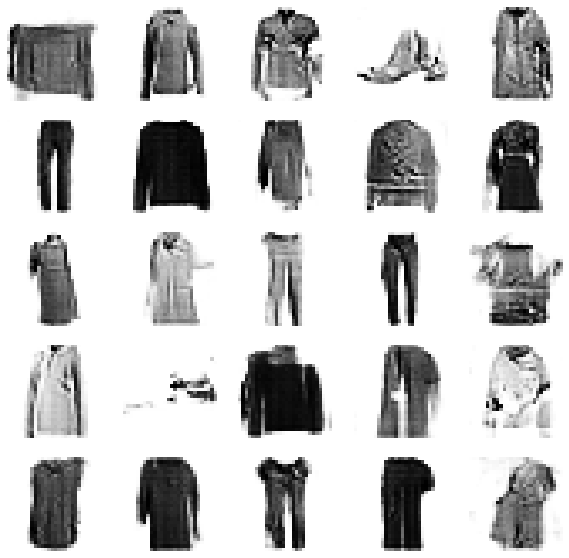

CPU times: user 6min 9s, sys: 18.1 s, total: 6min 27s
Wall time: 7min 1s


In [ ]:
# Eğitim gan modeli, tanımlanan dataset için belirlenen batch_size boyutu ve öznitelik sayısı ile
# 10 epoch olarak gerçekleşecek, siz de epoch sayısını değiştirerek modelin gelişimini gözlemlereyebilrisiniz.
%%time 
train_dcgan(gan, dataset, batch_size, num_features, epochs=10)

## 9.ADIM: DCGAN ile sentetik görüntülerin oluşturulması

Bu adımda en başta tanımladığımız `show` fonksiyonundan faydalanarak üretici ağın ürettiği sonuçları görselleştiriyoruz.

Her epoch için elde ettiğimiz sonuçları .png formatında kaydettikten sonra bunu .gif formatına dönüştürüp ekrana yazdırıyoruz ve dosyaya kaydediyoruz. 

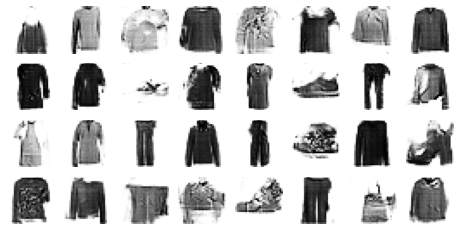

In [ ]:
noise = tf.random.normal(shape=[batch_size, num_features])
generated_images = generator(noise)
show(generated_images, 8)

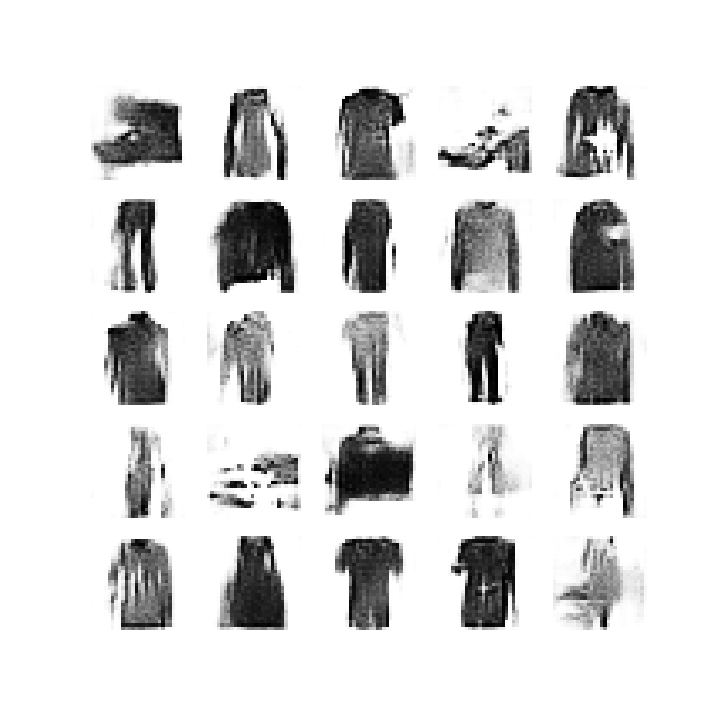

In [ ]:
# Sonuçları GIF olarak göstermek için bu kısmı çalıştırın.
## Kaynak: https://www.tensorflow.org/tutorials/generative/dcgan#create_a_gif
import imageio
import glob

anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  last = -1
  for i,filename in enumerate(filenames):
    frame = 2*(i)
    if round(frame) > round(last):
      last = frame
    else:
      continue
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

from IPython.display import Image
Image(open(anim_file,'rb').read())